<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Basic-Initialization" data-toc-modified-id="Basic-Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Initialization</a></span></li><li><span><a href="#Configure-Alazar" data-toc-modified-id="Configure-Alazar-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Configure Alazar</a></span></li></ul></div>

# Introduction

This is a simple check to see if data gets taken correctly with the Alazar. It should work independently of the model (if all our code is correct ;)). 

Requirements for running:
* a working Alazar
* some reasonable (CW) signal coming in that we know in advance. (so we can compare with the DSO program)

# Basic Initialization

In [1]:
%matplotlib notebook

from importlib import reload
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import qcodes as qc

from pytopo.qctools.instruments import create_inst, add2station

In [3]:
from qcodes.instrument_drivers.AlazarTech import ATS9360
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = create_inst(AlazarTech_ATS9360, 'alazar', force_new_instance=True)

from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl
raw_acq = create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)

station = qc.Station(raw_acq)

# Configure Alazar

Check the model and basic properties.

In [4]:
alazar.IDN()

{'firmware': None,
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970363',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.0.0',
 'SDK_version': '6.0.0',
 'latest_cal_date': '14-09-17',
 'memory_size': '4294967294',
 'asopc_type': '1779729248',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

Set some reasonable defaults for the card. Depends obviously on the model you're using, and the test signal.

In [5]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(1e9)
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.external_sample_rate(int(1e9))
    alazar.decimation(1)
    
    if alazar.IDN()['model'] != 'ATS9360':
        alazar.coupling1('DC')
        alazar.coupling2('DC')
        alazar.channel_range1(0.1)
        alazar.channel_range2(0.1)
        
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_source1('CHANNEL_A')
    alazar.trigger_level1(128 + 10)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_2V5')
    alazar.trigger_delay(0)
    alazar.timeout_ticks(int(1e7))

d:\onedrive\bf1\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:564: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


In [6]:
raw_acq.update_acquisitionkwargs(
    samples_per_record=128*10,
    records_per_buffer=10,
    buffers_per_acquisition=1,
)
data = raw_acq.acquisition()
print(data.shape)

'allocated_buffers' should be <= 'buffers_per_acquisition'. Defaulting 'allocated_buffers' to 1


(1, 10, 1280, 2)


<IPython.core.display.Javascript object>


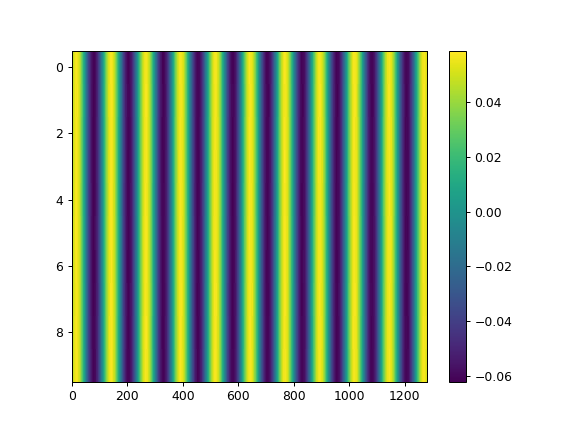

<IPython.core.display.Javascript object>


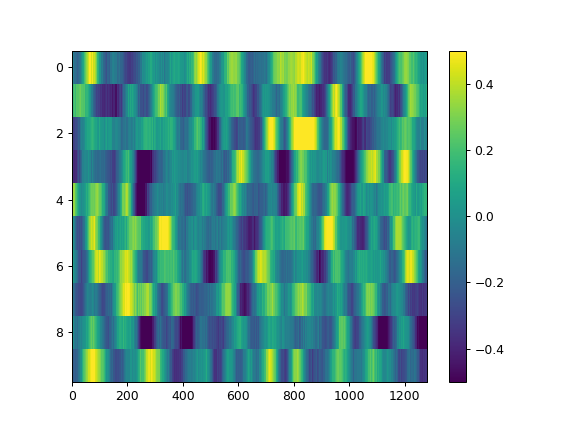

In [13]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(data[0, :, :, 0], aspect='auto')
cb = fig.colorbar(im)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(data[0, :, :, 1], aspect='auto')
cb = fig.colorbar(im)